# 🛒 E-Commerce Sales Analytics & Forecasting (Production-Grade)

This notebook builds a **business-ready sales analytics and forecasting system**
using **SQL Server transactional data** and **Facebook Prophet**.

The goal is not just prediction, but **decision support** for:
- Revenue planning
- Inventory management
- Marketing strategy


## 🎯 Business Problem

E-commerce companies face challenges such as:
- Uncertain future demand
- Overstocking or stockouts
- Inefficient marketing spend

This project addresses these challenges by:
- Analyzing historical sales
- Detecting anomalies
- Forecasting future demand with confidence intervals

## ⚙️ Environment Setup & Libraries

In [18]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

## 🗄️ SQL Server Connection

Transactional data is fetched directly from SQL Server
to simulate a real production environment.


In [3]:
conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=localhost;"
    "Database=EcommerceDB;"
    "Trusted_Connection=yes;"
)
print("Connected to SQL Server successfully!")

Connected to SQL Server successfully!


## 📥 Data Extraction

Daily sales are aggregated from order-level transactions.

In [19]:
query = """
SELECT 
    CAST(OrderDate AS DATE) AS OrderDate,
    SUM(TotalAmount) AS Sales
FROM Orders
GROUP BY CAST(OrderDate AS DATE)
ORDER BY OrderDate
"""

df = pd.read_sql(query, conn)
df.head()

C:\Users\Khushi\AppData\Local\Temp\ipykernel_30680\2383574898.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,OrderDate,Sales
0,2023-06-01,73000.0
1,2023-06-03,55000.0
2,2023-06-05,3000.0
3,2023-06-07,4500.0
4,2023-06-09,1200.0


## 🔍 Data Quality Checks

Ensuring data reliability before analysis and modeling.


In [20]:
df.info()
df.isna().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OrderDate  100 non-null    object 
 1   Sales      100 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


,Sales
count,100.000000
mean,29220.000000
std,31877.613183
min,1200.000000
25%,2800.000000
50%,8500.000000
75%,60000.000000
max,95000.000000


## 📊 Business KPIs

Key performance indicators derived from transactional data.

In [21]:
kpi_query = """
SELECT
    COUNT(DISTINCT OrderID) AS Total_Orders,
    COUNT(DISTINCT CustomerID) AS Total_Customers,
    SUM(TotalAmount) AS Total_Revenue,
    AVG(TotalAmount) AS Avg_Order_Value
FROM Orders
"""

kpis = pd.read_sql(kpi_query, conn)
kpis

C:\Users\Khushi\AppData\Local\Temp\ipykernel_30680\454362387.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  kpis = pd.read_sql(kpi_query, conn)


,Total_Orders,Total_Customers,Total_Revenue,Avg_Order_Value
0,100,100,2922000.0,29220.0


## 📈 Historical Sales Trend

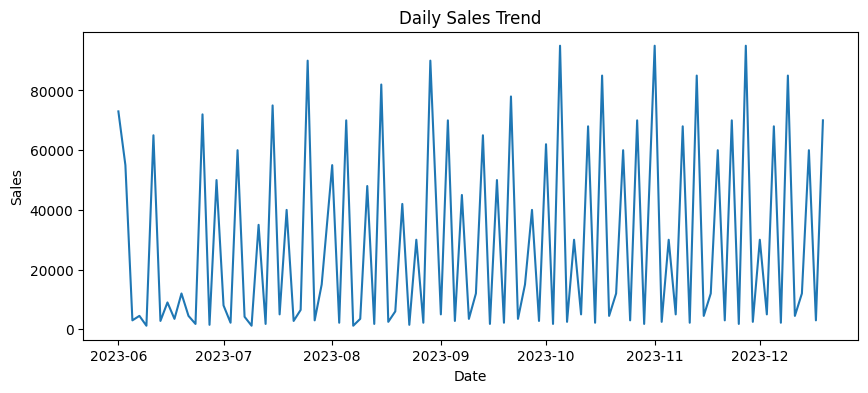

In [22]:
plt.figure(figsize=(10,4))
plt.plot(df['OrderDate'], df['Sales'])
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

## 🚨 Sales Anomaly Detection

Detecting abnormal spikes or drops that may impact forecasts.

In [23]:
df['rolling_mean'] = df['Sales'].rolling(7).mean()
df['rolling_std'] = df['Sales'].rolling(7).std()

df['anomaly'] = abs(df['Sales'] - df['rolling_mean']) > 2 * df['rolling_std']
df[df['anomaly'] == True].head()

,OrderDate,Sales,rolling_mean,rolling_std,anomaly
12,2023-06-25,72000.0,15085.714286,25362.467583,True


## 🔄 Data Preparation for Forecasting

In [24]:
df_prophet = df[['OrderDate', 'Sales']].rename(
    columns={'OrderDate': 'ds', 'Sales': 'y'}
)

df_prophet.head()

,ds,y
0,2023-06-01,73000.0
1,2023-06-03,55000.0
2,2023-06-05,3000.0
3,2023-06-07,4500.0
4,2023-06-09,1200.0


## 🤖 Prophet Model Training

Weekly and yearly seasonality enabled for business realism.

In [25]:
model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True
)

model.fit(df_prophet)

18:07:01 - cmdstanpy - INFO - Chain [1] start processing
18:07:01 - cmdstanpy - INFO - Chain [1] done processing


## 🔮 Sales Forecast (Next 30 Days)

In [26]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
125,2024-01-14,42752.653708,3398.812462,80933.991293
126,2024-01-15,42300.610088,2490.133804,85583.674600
127,2024-01-16,54231.922471,14373.011232,93368.765826
128,2024-01-17,37999.315823,-847.616533,80669.211049
129,2024-01-18,50174.741673,11451.728452,85877.064589


## 📊 Forecast Visualization

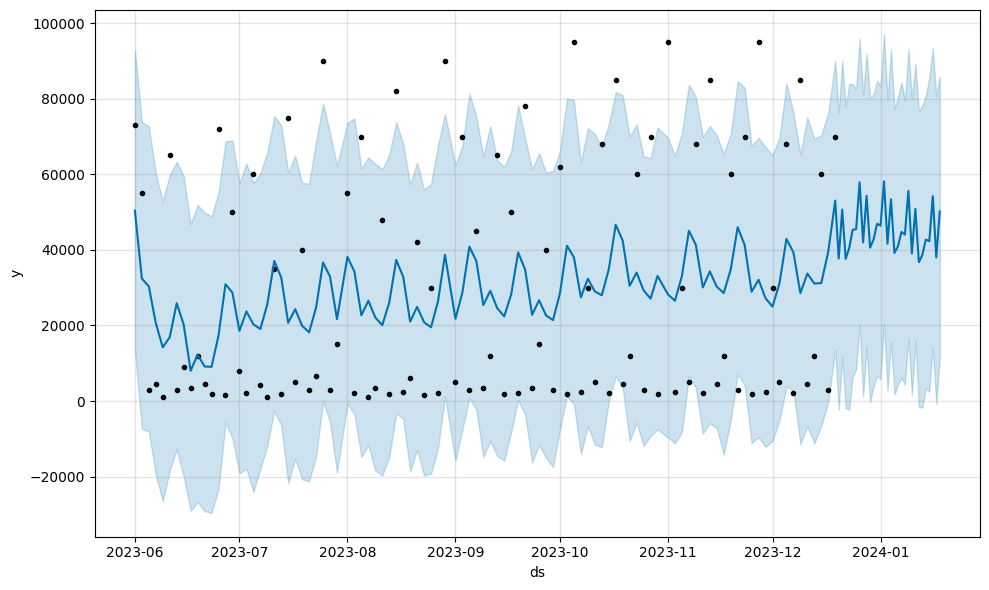

In [27]:
model.plot(forecast)
plt.show()

## 📉 Risk-Aware Forecast Interpretation

Lower bound used for conservative inventory planning.

## 🔮 What-If Scenario: Marketing Campaign Impact


In [28]:
forecast['yhat_campaign'] = forecast['yhat'] * 1.15
forecast[['ds', 'yhat', 'yhat_campaign']].tail()

,ds,yhat,yhat_campaign
125,2024-01-14,42752.653708,49165.551764
126,2024-01-15,42300.610088,48645.701601
127,2024-01-16,54231.922471,62366.710842
128,2024-01-17,37999.315823,43699.213197
129,2024-01-18,50174.741673,57700.952924


## ⚙️ Production Considerations

- Automated daily data ingestion from SQL Server
- Monthly model retraining
- Forecast storage for dashboards
- Anomaly alerts for sudden sales shifts